In [1]:
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
import joblib, uuid

warnings.filterwarnings("ignore")

In [ ]:
from v2.data_transformers.SurvivalAttritionTrsTransformer import SurvivalAttritionTrsTransformer

month = '10'
# 7/8/10 -> 31.#
report_date = f'2022-{month}-31'

input_paths = {
    'data': f'<path_to_file>.2022.csv',
    'training': f'<path_to_file>.csv',
}

outputh_paths = {
    'general':'<output_path>'
}

cleanup = False
transformer = SurvivalAttritionTrsTransformer(path_to_data=input_paths['data'],
                                                 training_data_path=input_paths['training'],
                                                 predict=False,
                                                 cleanup=False)

data = transformer.prepare_data_for_attrition_prediction(min_date='01.01.2018')

In [49]:
from dateutil import relativedelta


def calc_2(x, y):
    delta = relativedelta.relativedelta(x, y)
    return delta.months


def calc_month_before_termination(data):
    data['months_before_termination'] = ((data['max_date'] - data['report_date_dt']) / np.timedelta64(1, 'M'))
    data['months_before_termination'] = data['months_before_termination'].apply(lambda x: round(x))
    return data


def calc_month_of_work(data):
    # todo fix this calculation
    data['months_of_work'] = ((data['report_date_dt'] - data['start_date_dt']) / np.timedelta64(1, 'M'))
    data['months_of_work'] = data['months_of_work'].apply(lambda x: round(x))
    return data


def calculate_risk(x):
    if x <= 2:
        return 1
    else:
        return 0

def set_sample(x, y, intervals: int = 2):
    if x == 1:  # always take high risk periods
        return True

    #     if x == np.nan: # those are mid-periods we shouldn't consider
    #         return False

    if x == 0:  # low risk periods
        if y % intervals == 0:
            return True
        else:
            return False

def is_on_bench(x, y):
    # x = project, y = client
    x = x.lower()
    y = y.lower()
    if 'bench' in x or 'bench' in y:
        return 1
    elif 'internal' in y:
        return 1
    else:
        return 0

def avg_time_per_project(tenure, nth_project):
    return tenure / nth_project


def set_prob_period(x):
    if x < 3:
        return True
    else:
        return False


def get_tenure(x, y):
    months_of_empl = (y - x) / np.timedelta64(1, 'M')
    return months_of_empl / 12

def is_covid_employment(start_date):
    import datetime
    covid_start = datetime.datetime.strptime('20-03-2020', '%d-%m-%Y')
    covid_end = datetime.datetime.strptime('13-05-2022', '%d-%m-%Y')
    if covid_start < start_date < covid_end:
        return 1
    else:
        return 0

def get_time_to_event(date_column, event_column):
    return (risky[date_column] - risky.groupby(['unique_id', risky[event_column].eq(1).cumsum()])[date_column].transform("min"))/np.timedelta64(1, 'M')

In [50]:
data = calc_month_before_termination(data)
data = calc_month_of_work(data)

In [51]:
risky = data.copy()

In [52]:
risky.drop(['sampling', 'months_of_work', 'diff'], inplace=True, axis=1, errors='ignore')

In [53]:
risky['current project'].astype(str)
risky['client'].astype(str)
risky['current project'].fillna('No data', inplace=True)
risky['client'].fillna('No data', inplace=True)
risky['is_on_bench'] = risky.apply(lambda x: is_on_bench(x['current project'], x['client']), axis=1)

In [54]:
risky['tenure'] = risky.apply(lambda x: get_tenure(x['start_date_dt'], x['report_date_dt']), axis=1)

In [55]:
risky['is_covid_employment'] = risky['start_date_dt'].apply(is_covid_employment)

In [56]:
risky.sort_values(['unique_id', 'report_date_dt'], inplace=True)
risky['was_promoted'] = risky.groupby('unique_id').apply(
    lambda group: group['grade'] != group['grade'].shift(1)).tolist()
risky['was_promoted'] = risky['was_promoted'].map({True: 1, False: 0})
risky.loc[risky.groupby('unique_id').head(1).index, 'was_promoted'] = 1

In [57]:
risky['project_changed'] = risky.groupby('unique_id').apply(
    lambda group: group['current project'] != group['current project'].shift(1)).tolist()
risky['project_changed'] = risky['project_changed'].map({True: 1, False: 0})
risky.loc[risky.groupby('unique_id').head(1).index, 'project_changed'] = 0

In [58]:
risky['account_changed'] = risky.groupby('unique_id').apply(
    lambda group: group['client'] != group['client'].shift(1)).tolist()
risky['account_changed'] = risky['account_changed'].map({True: 1, False: 0})
risky.loc[risky.groupby('unique_id').head(1).index, 'account_changed'] = 0

In [59]:
risky["time_since_promo_in_months"] = get_time_to_event(date_column='report_date_dt', event_column='was_promoted')
risky["time_since_project_change_in_months"] = get_time_to_event(date_column='report_date_dt', event_column='project_changed')
risky["time_since_account_change_in_months"] = get_time_to_event(date_column='report_date_dt', event_column='account_changed')
risky["time_since_bench_in_months"] = get_time_to_event(date_column='report_date_dt', event_column='is_on_bench')
risky["time_since_training_in_months"] = get_time_to_event(date_column='report_date_dt', event_column='has_training')

In [60]:
risky.sort_values(['unique_id', 'report_date_dt'], inplace=True)
risky['bench_cumsum'] = risky.groupby(['unique_id'])['is_on_bench'].cumsum()

In [61]:
risky['bench_to_tenure'] = risky.apply(lambda x: (x['bench_cumsum'] / 12) / x['tenure'], axis=1)

In [62]:
risky['nth_project'] = risky.groupby(['unique_id'])[
                           'project_changed'].cumsum() + 1  # +1 beacuse it is reflecting the changes.

In [63]:
risky['avg_time_per_project'] = risky.apply(lambda x : avg_time_per_project(x['tenure'], x['nth_project']), axis=1)

In [64]:
risky.drop(['months_before_termination', 'months_of_work', 'grade', 'mapped_source', 'report_date',
            'bench_cumsum',
            'diff', 'initial_grade', 'max_report_date_all', 'max_date', 'technology', 'start_date_dt',
            'report_date_dt', 'Jjob family', 'source', 'status', 'division', 'technology', 'start date',
            'office location', 'contract type', 'client', 'current project', 'new_job_family', 'name', 'surname', 'grade', 'last_project', 'last_client', 'mapped_project', 'mapped_client', 'has_training'
            'is_on_bench', 'was_promoted', 'project_changed', 'account_changed'], axis=1, inplace=True,
           errors='ignore')
risky.drop(['has_training', 'is_on_bench'], axis=1, inplace=True,
           errors='ignore')

In [65]:
print(risky.shape)
print(risky.columns)

(44840, 22)
Index(['sap id', 'employee', 'unique_id', 'mapped_grade',
       'contract type_Contract', 'contract type_Permanent',
       'contract type_Sub-contract', 'contract type_Zlecenie', 'left',
       'office_location_prob_ratio', 'technology_prob_ratio',
       'mapped_client_prob_ratio', 'tenure', 'is_covid_employment',
       'time_since_promo_in_months', 'time_since_project_change_in_months',
       'time_since_account_change_in_months', 'time_since_bench_in_months',
       'time_since_training_in_months', 'bench_to_tenure', 'nth_project',
       'avg_time_per_project'],
      dtype='object')
(44840, 22)
Index(['sap id', 'employee', 'unique_id', 'mapped_grade',
       'contract type_Contract', 'contract type_Permanent',
       'contract type_Sub-contract', 'contract type_Zlecenie', 'left',
       'office_location_prob_ratio', 'technology_prob_ratio',
       'mapped_client_prob_ratio', 'tenure', 'is_covid_employment',
       'time_since_promo_in_months', 'time_since_project_c

In [67]:
data = data[data['left'] == 0]

In [68]:
data = risky.drop_duplicates(subset=['unique_id'], keep='last')

In [69]:
idx = data.index
emp_mapper = pd.DataFrame({'idx': idx,
                           'employee': data['employee'],
                           'churned': data['left'],
                           'tenure': data['tenure']})

In [ ]:
data.drop(['employee', 'unique_id'], axis=1, inplace=True)

emp_mapper.head()

In [73]:
from sksurv.ensemble import RandomSurvivalForest
import matplotlib.pyplot as plt
import joblib

# Load Model

In [74]:
model_file = f'models/surv_model_ff8a154a-7e90-40dc-90e5-c07d8da9344e.joblib'

with open(model_file, 'rb') as file:
    model = joblib.load(file)

In [75]:
idx_range = list(range(0, data.shape[0]))

In [76]:
idx = data.index
mapping ={}

for key, value in zip(idx_range, idx):
    mapping[key] = value

In [ ]:
emp_mapper.loc[mapping[384]]

In [78]:
data.drop(['contract type_Sub-contract', 'contract type_Zlecenie', 'left', 'sap id'], axis=1, inplace=True)

In [79]:
surv = model.predict_survival_function(data, return_array=True)

## Transform output data

In [80]:
def get_current_data_point(model, tenure:float, data_points_density: int = 10):  # we take every 10th data point (~ 5 months)
    evt_times = model.event_times_
    evt_times = pd.DataFrame(evt_times, columns=['time'])
    #evt_times = evt_times.iloc[::data_points_density, :]
    current_time_point = evt_times.iloc[(evt_times['time'] - tenure).abs().argsort()[:1]]
    related_data_point = current_time_point.index.values[0]
    return related_data_point

def get_survival_probability(survival_func_result, employee_index, data_point, data_points_density:int = 10):

    df_surv = pd.DataFrame(survival_func_result)
    #df_surv = df_surv[df_surv.columns[::data_points_density]]

    max_data_point = df_surv.iloc[: , -1].name

    churn_prob_now = 1 - df_surv.loc[df_surv.index[employee_index], data_point]
    future_data_point = data_point + data_points_density
    if future_data_point > max_data_point:
        future_data_point = max_data_point
    churn_prob_in_future = 1 - df_surv.loc[df_surv.index[employee_index], future_data_point]
    return (churn_prob_now, churn_prob_in_future)


In [81]:
test_data = data.copy(deep=True)

In [82]:
test_data.reset_index(inplace=True)
test_data.rename(columns={'index': 'idx'}, inplace=True)

In [84]:
test_data['current_data_point'] = test_data.apply(lambda x: get_current_data_point(model, x['tenure']), axis=1)
test_data['probabilities'] = test_data.apply(lambda x: get_survival_probability(surv, x.name, x['current_data_point']), axis=1)
prediction_data = test_data[['idx', 'probabilities', 'current_data_point', 'tenure']]

In [85]:
mapper = emp_mapper[['employee', 'idx']]

In [86]:
prediction_data = prediction_data.merge(mapper, on='idx')
prediction_data['report_date'] = report_date

In [ ]:
prediction_data[['risk_t0', 'risk_t5']] = pd.DataFrame(prediction_data['probabilities'].tolist(), index=prediction_data.index)
prediction_data = prediction_data.drop(['probabilities'], axis=1)
prediction_data

In [88]:
append_with_survival = True
save = False

if append_with_survival:
    existing_pred_file = 'all_predictions_grade.xlsx'
    d = pd.read_excel(existing_pred_file)
    d = d.merge(prediction_data, left_on=['employee', 'inference_date'], right_on=['employee', 'report_date'], how='left')
    d = d.drop(['Unnamed: 0', 'report_date', 'idx'], axis=1)
    if save:
        d.to_excel('all_predictions_grade.xlsx')
    print(d.shape)

(7683, 13)
(7683, 13)


In [109]:
surv = model.predict_survival_function(data, return_array=True)

In [116]:
idx = 1392

survival_single = pd.DataFrame(surv)
survival_single = survival_single[survival_single.index == idx]


,0,1,2,3,4,5,6,7,8,9,...,327,328,329,330,331,332,333,334,335,336
1392,0.999513,0.999513,0.999513,0.999513,0.999513,0.99899,0.99813,0.99813,0.99813,0.99813,...,0.519599,0.515158,0.507496,0.50633,0.499062,0.498085,0.471235,0.462839,0.459322,0.386281


In [ ]:
name = emp_mapper.loc[mapping[idx], 'employee']

plt.step(model.event_times_, survival_single, where="post", label=str(name))
plt.ylabel("Survival probability")
plt.xlabel("Time in years")
plt.legend()
plt.grid(True)

In [108]:
surv = pd.DataFrame(surv)
surv

,0
0,0.999513
1,0.999513
2,0.999513
3,0.999513
4,0.999513
...,...
332,0.498085
333,0.471235
334,0.462839
335,0.459322


# POST PRED OPERATIONS

In [5]:
data = pd.read_excel('all_predictions_grade.xlsx', index_col=0)

In [6]:
data.columns

Index(['employee', 'account', 'grade', 'inference_date', 'at_risk',
       'probability', 'risk_bucket', 'risk_t0', 'risk_t5'],
      dtype='object')

In [7]:
def get_risk_bucket(x):
    if x <= 0.5:
        return 'no risk'
    elif x <= 0.7:
        return 'low risk'
    elif x <= 0.8:
        return 'moderate risk'
    elif x <= 0.9:
        return 'high risk'
    else:
        return 'very high risk'

def surv_calculate_change(risk_t0, risk_t5):
    change = 1 # increase or decrease in terms of change
    if risk_t5 < risk_t0:
        change = -1

    diff = risk_t5 - risk_t0
    return (diff / risk_t0) * 100 * change


In [ ]:
data["survival_mean_risk"] = data.loc[:, ['risk_t0','risk_t5']].mean(axis = 1)
data

In [ ]:
data['survival_change_in_perc'] = data.apply(lambda x: surv_calculate_change(x['risk_t0'], x['risk_t5']), axis=1)
data

In [10]:
from v2.db.db_helper import connect_to_db, select_test
engine = connect_to_db()

In [11]:
schema = 'public'
table = 'predictions'

In [13]:
data.to_sql(table, con=engine, if_exists='append', schema=schema)

# Survival validation

In [15]:
# FILTERING OPTIONS
validate_data = True
account_filter = False
grade_filter = False
chosen_account = 'acc'

def filter_by_account(data, chosen_account):
    # possible triming on account name and lowering case
    if chosen_account != 'all':
        filtered_df = data['account'].str.contains(f'{chosen_account}')
        # data[data['account'] == chosen_account]
        return data[filtered_df]

def filter_by_grade(x):
    excluded_grades = ['L6', 'L7']
    if x in excluded_grades:
        return False
    else:
        return True

In [16]:
# GET PEOPLE WHO LEFT - LESS THAN X PRED POINTS
n_preds = 7
if validate_data:
    data = data.groupby(['employee']).filter(lambda x: len(x) < n_preds)
    data = data.groupby(['employee']).filter(lambda x: x['inference_date'].head(1) == '2022-06-30')
    data = data.groupby(['employee']).filter(lambda x: x['inference_date'].tail(1) != '2022-12-30')
    data = data.drop_duplicates(subset=['employee'], keep='last')

In [17]:
if account_filter:
    data = filter_by_account(data, chosen_account)

### filter by grade

In [18]:
if grade_filter:
    data['to_show'] = data['grade'].apply(filter_by_grade)
    data['to_show'].value_counts()
    data = data[data['to_show'] == True]
    data = data.drop(['to_show'], axis=1)

<AxesSubplot:ylabel='Frequency'>

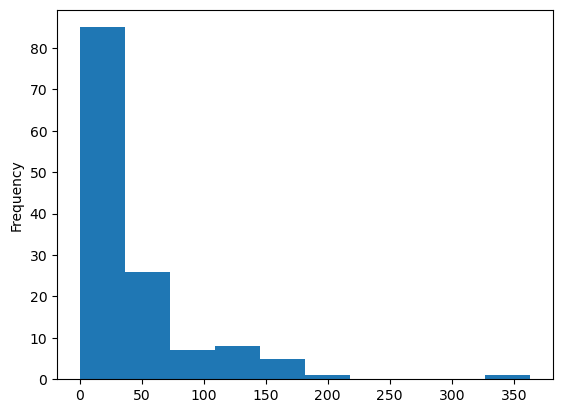

In [24]:
data['survival_change_in_perc'].plot(kind='hist')

In [35]:
def get_even_buckets(x):
    if x < 10: return 'A<10'
    elif x < 20: return 'B10-20'
    elif x < 30: return 'C20-30'
    elif x < 40: return 'D30-40'
    elif x < 50: return 'E40-50'
    elif x < 60: return 'F50-60'
    elif x < 70: return 'G60-70'
    elif x < 80: return 'H70-80'
    elif x < 90: return 'I80-90'
    elif x < 100: return 'J90-100'
    else: return 'K> 100'

<AxesSubplot:>

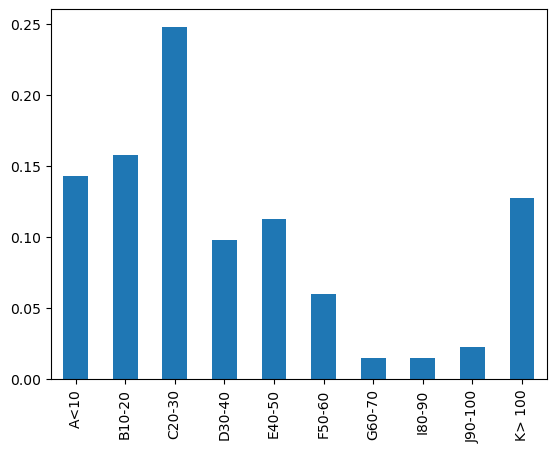

In [38]:
data['change_bucket_even'] = data['survival_change_in_perc'].apply(get_even_buckets)
data['change_bucket_even'].value_counts(normalize = True).sort_index(ascending=True).plot(kind = 'bar')


In [20]:
def get_buckets_survival_risk_change(surv_risk_change):
    if surv_risk_change < 20:
        return 'small change'
    elif surv_risk_change < 40:
        return 'medium change'
    elif surv_risk_change < 60:
        return 'big change'
    else:
        return 'very big change'

In [21]:
data['bucket_change'] = data['survival_change_in_perc'].apply(get_buckets_survival_risk_change)
data['bucket_change'].value_counts()

medium change      46
small change       40
very big change    24
big change         23
Name: bucket_change, dtype: int64

In [22]:
data['mean_survival_risk_bucket'] = data['survival_mean_risk'].apply(get_risk_bucket)
data['mean_survival_risk_bucket'].value_counts()

no risk          120
low risk          12
moderate risk      1
Name: mean_survival_risk_bucket, dtype: int64

In [ ]:
summary = data['risk_bucket'].value_counts(normalize=True)
if validate_data:
    summary.to_excel(f'summary_val_{chosen_account}.xlsx')
else:
    summary.to_excel(f'summary_all_{chosen_account}.xlsx')